In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model._logistic import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
import xgboost as xgb
from xgboost.sklearn import XGBClassifier
from sklearn.metrics import accuracy_score, recall_score, f1_score, roc_auc_score
import warnings
import logging
from sklearn.decomposition import PCA
from collections import Counter
from imblearn.over_sampling import RandomOverSampler
from sklearn.model_selection import StratifiedShuffleSplit
from imblearn.over_sampling import SMOTE
from sklearn.naive_bayes import GaussianNB, MultinomialNB, BernoulliNB
from sklearn import svm
from sklearn.neural_network import MLPClassifier
from keras.models import Sequential
from keras.layers import Dense, Dropout
from openpyxl import Workbook, load_workbook
import itertools
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

2022-05-20 09:59:42.560150: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-05-20 09:59:42.560233: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [2]:
warnings.filterwarnings('ignore')

data_path = r'FlightDelays.csv'
output_path = 'result.xlsx'

pd.set_option('display.max_columns', None)
pd.set_option('display.width', 200)
# 获取数据
logging.basicConfig(format='%(asctime)s %(message)s')
logging.warning('------FlightDelays------')
data = pd.read_csv(data_path)
# ['schedtime', 'carrier', 'deptime', 'dest', 'distance', 'date', 'flightnumber', 'origin', 'weather', 'dayweek',
# 'daymonth', 'tailnu', 'delay']
# carrier, dest, origin, tailnu字符型数据，需要转换成数值型并离散化
# date应该删除
# delay是标签
data = data.dropna()
data = data.reset_index(drop=True)

# 分析数据，发现类别不平衡
print(Counter(data['delay']))  # Counter({'ontime': 1773, 'delayed': 428})
print("存在类别不平衡问题")
print()
"""
labels = list(set(data['delay']))  # ['ontime', 'delayed']
group_data = data.groupby(['delay']).delay.count()
print(group_data)
# delayed:ontime 428:1773
"""
y_mapping = {'delayed': 1, 'ontime': 0}
data['delay'] = data['delay'].map(y_mapping)
data

2022-05-20 09:59:45,576 ------FlightDelays------


Counter({'ontime': 1773, 'delayed': 428})
存在类别不平衡问题



,schedtime,carrier,deptime,dest,distance,date,flightnumber,origin,weather,dayweek,daymonth,tailnu,delay
0,1455,OH,1455,JFK,184,1/1/2004,5935,BWI,0,4,1,N940CA,0
1,1640,DH,1640,JFK,213,1/1/2004,6155,DCA,0,4,1,N405FJ,0
2,1245,DH,1245,LGA,229,1/1/2004,7208,IAD,0,4,1,N695BR,0
3,1715,DH,1709,LGA,229,1/1/2004,7215,IAD,0,4,1,N662BR,0
4,1039,DH,1035,LGA,229,1/1/2004,7792,IAD,0,4,1,N698BR,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2196,645,RU,644,EWR,199,1/31/2004,2761,DCA,0,6,31,N15555,0
2197,1700,RU,1653,EWR,213,1/31/2004,2497,IAD,0,6,31,N16976,0
2198,1600,RU,1558,EWR,199,1/31/2004,2361,DCA,0,6,31,N14902,0
2199,1359,RU,1403,EWR,199,1/31/2004,2216,DCA,0,6,31,N16961,0


In [3]:
# 处理数据
# 名义变量，df是使用one-hot编码的数据
c = list(set(data['carrier']))  # ['OH', 'RU', 'US', 'DL', 'MQ', 'CO', 'DH', 'UA']
carrier = pd.get_dummies(data['carrier'], prefix='carrier')
data.drop('carrier', axis=1, inplace=True)
d = list(set(data['dest']))  # ['JFK', 'LGA', 'EWR']
dest = pd.get_dummies(data['dest'], prefix='dest')
data.drop('dest', axis=1, inplace=True)
o = list(set(data['origin']))  # ['BWI', 'DCA', 'IAD']
origin = pd.get_dummies(data['origin'], prefix='origin')
data.drop('origin', axis=1, inplace=True)
t = list(set(data['tailnu']))  
tailnu = pd.get_dummies(data['tailnu'], prefix='tailnu')  #
data.drop('tailnu', axis=1, inplace=True)
df = pd.concat([data, carrier, dest, origin], axis=1)
df.drop('date', axis=1, inplace=True)
df.drop('schedtime', axis=1, inplace=True)
df.drop('deptime', axis=1, inplace=True)
df.drop('distance', axis=1, inplace=True)
df.drop('flightnumber', axis=1, inplace=True)
df.drop('daymonth', axis=1, inplace=True)
# 共17个特征


In [4]:
df.head()

,weather,dayweek,delay,carrier_CO,carrier_DH,carrier_DL,carrier_MQ,carrier_OH,carrier_RU,carrier_UA,carrier_US,dest_EWR,dest_JFK,dest_LGA,origin_BWI,origin_DCA,origin_IAD
0,0,4,0,0,0,0,0,1,0,0,0,0,1,0,1,0,0
1,0,4,0,0,1,0,0,0,0,0,0,0,1,0,0,1,0
2,0,4,0,0,1,0,0,0,0,0,0,0,0,1,0,0,1
3,0,4,0,0,1,0,0,0,0,0,0,0,0,1,0,0,1
4,0,4,0,0,1,0,0,0,0,0,0,0,0,1,0,0,1


In [5]:
# pca一下
pca_df = df.iloc[1:]
vector = np.array(pca_df)
pca = PCA(n_components=1, copy=True, whiten=False)
new_vec = pca.fit_transform(vector)  # array
# print(pca.explained_variance_ratio_)  # [9.38692389e-01 6.07668022e-02 5.04334816e-04]



In [6]:
# 绘制混淆矩阵
def plot_confusion_matrix(cm, classes, name, title='Confusion matrix', cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=0)
    plt.yticks(tick_marks, classes)

    threshold = cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(i, j, cm[i, j], horizontalalignment='center', color="white" if cm[i, j] > threshold else "black")
    plt.tight_layout()
    plt.ylabel("True label")
    plt.xlabel("Prediction label")
    #print("召回率：", cm[1, 1] / cm[1].sum())
    plt.show()
    plt.savefig('recall%s.png' % name, bbox_inches='tight')


In [7]:
def LR(x_train, x_test, y_train, y_test):
    print('------1.LogisticRegression------')
    lr = LogisticRegression()
    lr.fit(x_train, y_train)
    acc_train = lr.score(x_train, y_train)
    # print('accuracy on train set:', acc_train)
    y_test_predict = lr.predict(x_test)
    acc_test = lr.score(x_test, y_test)
    print('accuracy on test set:', acc_test)
    acc = accuracy_score(y_test, y_test_predict)
    recall = recall_score(y_test, y_test_predict)
    f1 = f1_score(y_test, y_test_predict, average='macro')
    print('recall:', recall)
    print('f1:', f1)
    auc = roc_auc_score(y_test, y_test_predict)
    print('AUC:', auc)
    # joblib.dump(lr, "model_LR.pkl")
    cm = confusion_matrix(y_test, y_test_predict)
    plot_confusion_matrix(cm, classes=[0, 1], name='LR')
    return acc_test, f1, recall, auc



In [8]:
def DT(x_train, x_test, y_train, y_test):
    print('------2.DecisionTree------')
    dt = DecisionTreeClassifier()
    dt.fit(x_train, y_train)
    acc_train = dt.score(x_train, y_train)
    acc_test = dt.score(x_test, y_test)
    y_test_predict = dt.predict(x_test)
    # print('accuracy on train set:', acc_train)
    print('accuracy on test set:', acc_test)
    acc = accuracy_score(y_test, y_test_predict)
    recall = recall_score(y_test, y_test_predict)
    f1 = f1_score(y_test, y_test_predict, average='macro')
    print('recall:', recall)
    print('f1:', f1)
    auc = roc_auc_score(y_test, y_test_predict)
    print('AUC:', auc)
    # joblib.dump(dt, "model_DT.pkl")
    cm = confusion_matrix(y_test, y_test_predict)
    plot_confusion_matrix(cm, classes=[0, 1], name='DT')
    return acc_test, f1, recall, auc


In [9]:
def RF(x_train, x_test, y_train, y_test):
    print('------3.RandomForest------')
    rf = RandomForestClassifier(n_estimators=1000)
    rf.fit(x_train, y_train)
    acc_train = rf.score(x_train, y_train)
    acc_test = rf.score(x_test, y_test)
    y_test_predict = rf.predict(x_test)
    # print('accuracy on train set:', acc_train)
    print('accuracy on test set:', acc_test)
    acc = accuracy_score(y_test, y_test_predict)
    recall = recall_score(y_test, y_test_predict)
    f1 = f1_score(y_test, y_test_predict, average='macro')
    print('recall:', recall)
    print('f1:', f1)
    auc = roc_auc_score(y_test, y_test_predict)
    print('AUC:', auc)
    # joblib.dump(rf, "model_RF.pkl")
    cm = confusion_matrix(y_test, y_test_predict)
    plot_confusion_matrix(cm, classes=[0, 1], name='RF')
    return acc_test, f1, recall, auc



In [10]:
def RFweight(x_train, x_test, y_train, y_test):
    print('------4.RandomForest with weight------')
    rf = RandomForestClassifier(n_estimators=1000, class_weight='balanced')
    rf1 = RandomForestClassifier(n_estimators=1000, class_weight={0: 0.1, 1: 0.9})
    rf.fit(x_train, y_train)
    acc_train = rf.score(x_train, y_train)
    acc_test = rf.score(x_test, y_test)
    y_test_predict = rf.predict(x_test)
    # print('accuracy on train set:', acc_train)
    print('accuracy on test set(balanced):', acc_test)
    acc = accuracy_score(y_test, y_test_predict)
    recall = recall_score(y_test, y_test_predict)
    f1 = f1_score(y_test, y_test_predict, average='macro')
    print('recall(balanced):', recall)
    print('f1(balanced):', f1)
    auc = roc_auc_score(y_test, y_test_predict)
    print('AUC(balanced):', auc)
    # joblib.dump(rf, "model_RF.pkl")
    print()
    rf1.fit(x_train, y_train)
    acc_test1 = rf1.score(x_test, y_test)
    y_test_predict1 = rf1.predict(x_test)
    print('accuracy on test set(weight):', acc_test1)
    recall1 = recall_score(y_test, y_test_predict1)
    f11 = f1_score(y_test, y_test_predict1, average='macro')
    print('recall(weight):', recall1)
    print('f1(weight):', f11)
    auc1 = roc_auc_score(y_test, y_test_predict1)
    print('AUC(weight):', auc1)
    cm = confusion_matrix(y_test, y_test_predict)
    plot_confusion_matrix(cm, classes=[0, 1], name='RFweight')
    return acc_test1, f11, recall1, auc1

In [11]:
def XGB(x_train, x_test, y_train, y_test):
    print('------5.XGBoost------')
    xgb1 = XGBClassifier(
        learning_rate=0.1,
        n_estimators=1000,
        max_depth=5,
        min_child_weight=1,
        gamma=0,
        subsample=0.8,
        colsample_bytree=0.8,
        objective='binary:logistic',
        nthread=4,
        scale_pos_weight=1,
        seed=27,
        eval_metric=['logloss', 'auc', 'error'])
    dtrain = xgb.DMatrix(x_train, label=y_train)
    dtest = xgb.DMatrix(x_test)
    xgb1.fit(x_train, y_train)
    acc_train = xgb1.score(x_train, y_train)
    acc_test = xgb1.score(x_test, y_test)
    y_test_predict = xgb1.predict(x_test)
    # print('accuracy on train set:', acc_train)
    print('accuracy on test set:', acc_test)
    acc = accuracy_score(y_test, y_test_predict)
    recall = recall_score(y_test, y_test_predict)
    f1 = f1_score(y_test, y_test_predict, average='macro')
    print('recall:', recall)
    print('f1:', f1)
    auc = roc_auc_score(y_test, y_test_predict)
    print('AUC:', auc)
    # joblib.dump(xgb1, "model_XGB.pkl")
    cm = confusion_matrix(y_test, y_test_predict)
    plot_confusion_matrix(cm, classes=[0, 1], name='XGB')
    return acc_test, f1, recall, auc



In [12]:
def NB_Gaussian(x_train, x_test, y_train, y_test):
    print('------6.Gaussian Naive Bayes------')
    clf = GaussianNB()
    clf.fit(x_train, y_train)
    y_test_predict = clf.predict(x_test)
    acc_test = clf.score(x_test, y_test)
    print('accuracy on test set(Gaussian):', acc_test)
    recall = recall_score(y_test, y_test_predict)
    f1 = f1_score(y_test, y_test_predict, average='macro')
    print('recall(Gaussian):', recall)
    print('f1(Gaussian):', f1)
    auc = roc_auc_score(y_test, y_test_predict)
    print('AUC(Gaussian):', auc)
    # joblib.dump(xgb1, "model_XGB.pkl")
    cm = confusion_matrix(y_test, y_test_predict)
    plot_confusion_matrix(cm, classes=[0, 1], name='NBG')
    return acc_test, f1, recall, auc


In [13]:
def NB_Bernoulli(x_train, x_test, y_train, y_test):
    print('------7.Bernoulli Naive Bayes------')
    clf = BernoulliNB()
    clf.fit(x_train, y_train)
    y_test_predict = clf.predict(x_test)
    acc_test = clf.score(x_test, y_test)
    print('accuracy on test set(Bernoulli):', acc_test)
    recall = recall_score(y_test, y_test_predict)
    f1 = f1_score(y_test, y_test_predict, average='macro')
    print('recall(Bernoulli):', recall)
    print('f1(Bernoulli):', f1)
    auc = roc_auc_score(y_test, y_test_predict)
    print('AUC(Bernoulli):', auc)
    # joblib.dump(xgb1, "model_XGB.pkl")
    cm = confusion_matrix(y_test, y_test_predict)
    plot_confusion_matrix(cm, classes=[0, 1], name='NBB')
    return acc_test, f1, recall, auc


In [14]:
def SVM(x_train, x_test, y_train, y_test):
    print('------8.SVM------')
    model = svm.SVC(C=5, decision_function_shape='ovo', gamma=0.1)
    model.fit(x_train, y_train)
    y_test_predict = model.predict(x_test)
    acc_test = model.score(x_test, y_test)
    print('accuracy on test set(Bernoulli):', acc_test)
    recall = recall_score(y_test, y_test_predict)
    f1 = f1_score(y_test, y_test_predict, average='macro')
    print('recall(Bernoulli):', recall)
    print('f1(Bernoulli):', f1)
    auc = roc_auc_score(y_test, y_test_predict)
    print('AUC(Bernoulli):', auc)
    # joblib.dump(xgb1, "model_XGB.pkl")
    cm = confusion_matrix(y_test, y_test_predict)
    plot_confusion_matrix(cm, classes=[0, 1], name='SVM')
    return acc_test, f1, recall, auc

In [15]:
def MLP(x_train, x_test, y_train, y_test):
    # 多层感知机，普通的前馈神经网络
    print('------9.MLP------')
    mlp = MLPClassifier(solver='lbfgs', activation="relu", hidden_layer_sizes=[10, 5], max_iter=100000)
    mlp.fit(x_train, y_train)
    y_test_predict = mlp.predict(x_test)
    acc_test = mlp.score(x_test, y_test)
    print('accuracy on test set(Bernoulli):', acc_test)
    recall = recall_score(y_test, y_test_predict)
    f1 = f1_score(y_test, y_test_predict, average='macro')
    print('recall(Bernoulli):', recall)
    print('f1(Bernoulli):', f1)
    auc = roc_auc_score(y_test, y_test_predict)
    print('AUC(Bernoulli):', auc)
    cm = confusion_matrix(y_test, y_test_predict)
    plot_confusion_matrix(cm, classes=[0, 1], name='MLP')
    return acc_test, f1, recall, auc

In [16]:
def lstm(x_train, x_test, y_train, y_test):
    print('------10.LSTM------')
    model = Sequential()
    model.add(Dense(64, input_dim=16, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(1, activation='sigmoid'))
    # 编译模型，定义损失函数，优化函数，绩效评估函数
    # binary_crossentropy一般搭配sigmoid激活函数使用
    model.compile(loss='binary_crossentropy',
                  optimizer='rmsprop',
                  metrics=['accuracy'])
    model.fit(x_train, y_train, epochs=20, batch_size=128)
    score = model.evaluate(x_test, y_test, batch_size=128)
    # acc = accuracy_score(y_test, y_test_predict)
    print('loss on test set:', score[0])
    print('accuracy on test set:', score[1])
    return score[0], score[1]



------随机划分数据------
训练集类分布:
Counter({0: 1414, 1: 346})
------1.LogisticRegression------
accuracy on test set: 0.8390022675736961
recall: 0.13414634146341464
f1: 0.5732859070280878
AUC: 0.5670731707317074


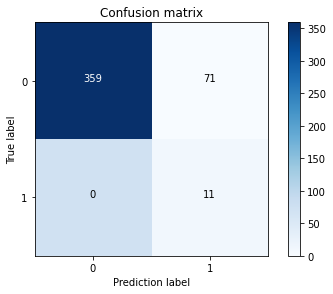

------2.DecisionTree------
accuracy on test set: 0.8276643990929705
recall: 0.15853658536585366
f1: 0.5787330316742081
AUC: 0.5695189890617569


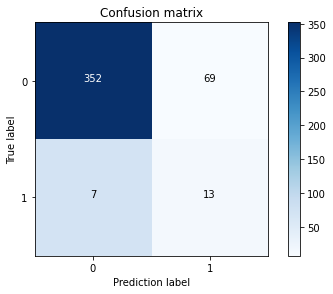

------3.RandomForest------
accuracy on test set: 0.8276643990929705
recall: 0.15853658536585366
f1: 0.5787330316742081
AUC: 0.5695189890617569


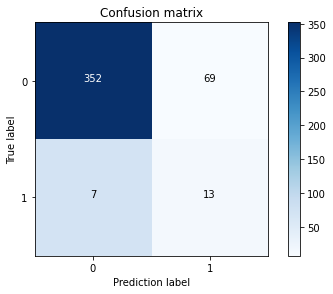

------4.RandomForest with weight------
accuracy on test set(balanced): 0.673469387755102
recall(balanced): 0.6341463414634146
f1(balanced): 0.5961127505851226
AUC(balanced): 0.6582987974726544

accuracy on test set(weight): 0.5170068027210885
recall(weight): 0.8048780487804879
f1(weight): 0.49298032547971826
AUC(weight): 0.6280657653373192


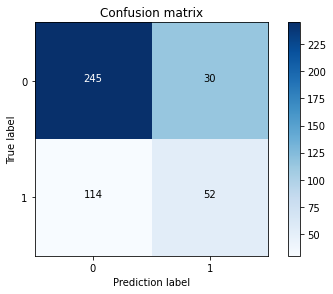

------5.XGBoost------
accuracy on test set: 0.8253968253968254
recall: 0.18292682926829268
f1: 0.5905094965330118
AUC: 0.577535838032475


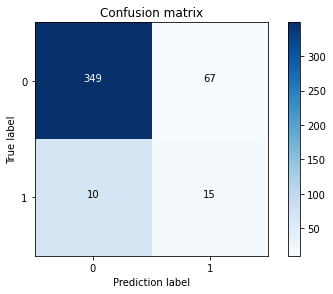

------6.Gaussian Naive Bayes------
accuracy on test set(Gaussian): 0.8390022675736961
recall(Gaussian): 0.13414634146341464
f1(Gaussian): 0.5732859070280878
AUC(Gaussian): 0.5670731707317074


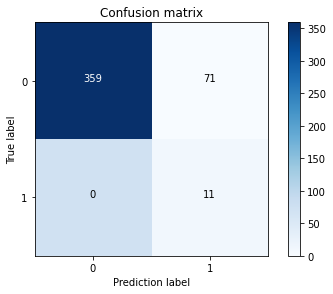

------7.Bernoulli Naive Bayes------
accuracy on test set(Bernoulli): 0.7981859410430839
recall(Bernoulli): 0.18292682926829268
f1(Bernoulli): 0.5677280086346466
AUC(Bernoulli): 0.5608227461104695


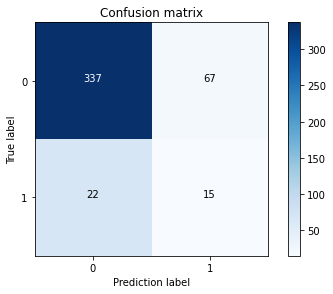

------8.SVM------
accuracy on test set(Bernoulli): 0.8344671201814059
recall(Bernoulli): 0.13414634146341464
f1(Bernoulli): 0.5694108205711229
AUC(Bernoulli): 0.5642876554113732


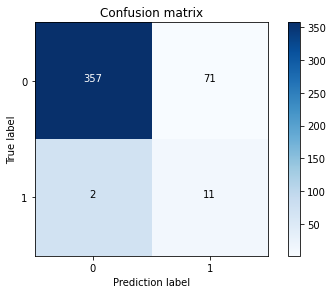

------9.MLP------
accuracy on test set(Bernoulli): 0.8208616780045351
recall(Bernoulli): 0.15853658536585366
f1(Bernoulli): 0.572972972972973
AUC(Bernoulli): 0.5653407160812555


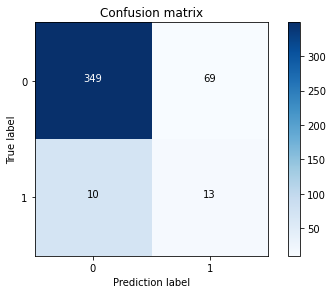

------10.LSTM------
Epoch 1/20


2022-05-20 10:00:16.630317: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-05-20 10:00:16.630396: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-05-20 10:00:16.630436: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (DESKTOP-39J4AD4): /proc/driver/nvidia/version does not exist
2022-05-20 10:00:16.630904: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


14/14 [==============================] - 1s 4ms/step - loss: 0.6103 - accuracy: 0.7114
Epoch 2/20
14/14 [==============================] - 0s 4ms/step - loss: 0.5594 - accuracy: 0.7864
Epoch 3/20
14/14 [==============================] - 0s 3ms/step - loss: 0.5425 - accuracy: 0.7864
Epoch 4/20
14/14 [==============================] - 0s 5ms/step - loss: 0.5333 - accuracy: 0.7892
Epoch 5/20
14/14 [==============================] - 0s 3ms/step - loss: 0.5243 - accuracy: 0.7972
Epoch 6/20
14/14 [==============================] - 0s 3ms/step - loss: 0.5257 - accuracy: 0.7972
Epoch 7/20
14/14 [==============================] - 0s 3ms/step - loss: 0.5302 - accuracy: 0.7972
Epoch 8/20
14/14 [==============================] - 0s 3ms/step - loss: 0.5067 - accuracy: 0.8028
Epoch 9/20
14/14 [==============================] - 0s 4ms/step - loss: 0.5066 - accuracy: 0.8040
Epoch 10/20
14/14 [==============================] - 0s 3ms/step - loss: 0.5103 - accuracy: 0.8028
Epoch 11/20
14/14 [===========

<Figure size 432x288 with 0 Axes>

In [17]:
print('------随机划分数据------')
y = df['delay'].copy()
df.drop('delay', axis=1, inplace=True)
x_train, x_test, y_train, y_test = train_test_split(df, y, test_size=0.2, random_state=1)
print('训练集类分布:')
print(Counter(y_train))
acc_test0, f10, recall0, auc0 = LR(x_train, x_test, y_train, y_test)
acc_test1, f11, recall1, auc1 = DT(x_train, x_test, y_train, y_test)
acc_test2, f12, recall2, auc2 = RF(x_train, x_test, y_train, y_test)
acc_test3, f13, recall3, auc3 = RFweight(x_train, x_test, y_train, y_test)
acc_test4, f14, recall4, auc4 = XGB(x_train, x_test, y_train, y_test)
acc_test5, f15, recall5, auc5 = NB_Gaussian(x_train, x_test, y_train, y_test)
acc_test6, f16, recall6, auc6 = NB_Bernoulli(x_train, x_test, y_train, y_test)
acc_test7, f17, recall7, auc7 = SVM(x_train, x_test, y_train, y_test)
acc_test8, f18, recall8, auc8 = MLP(x_train, x_test, y_train, y_test)
loss, acc_test9 = lstm(x_train, x_test, y_train, y_test)


------随机过采样------
Counter({0: 1773, 1: 1773})
训练集类分布:
Counter({0: 1418, 1: 1418})
------1.LogisticRegression------
accuracy on test set: 0.6169014084507042
recall: 0.7295774647887324
f1: 0.611975085392807
AUC: 0.6169014084507042


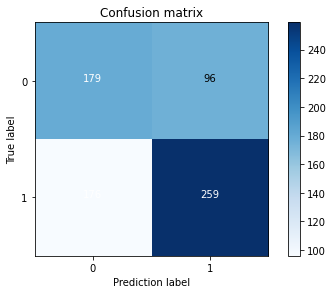

------2.DecisionTree------
accuracy on test set: 0.6830985915492958
recall: 0.7070422535211267
f1: 0.6829168080887476
AUC: 0.6830985915492958


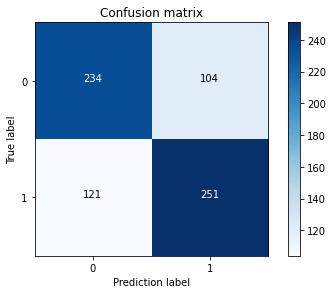

------3.RandomForest------
accuracy on test set: 0.6929577464788732
recall: 0.7323943661971831
f1: 0.6924794761144093
AUC: 0.6929577464788732


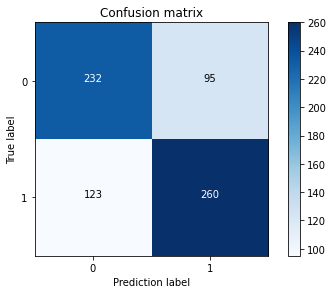

------4.RandomForest with weight------
accuracy on test set(balanced): 0.6845070422535211
recall(balanced): 0.7126760563380282
f1(balanced): 0.6842565018860433
AUC(balanced): 0.6845070422535211

accuracy on test set(weight): 0.5535211267605634
recall(weight): 0.9943661971830986
f1(weight): 0.44581920611822295
AUC(weight): 0.5535211267605633


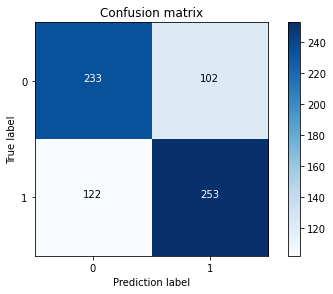

------5.XGBoost------
accuracy on test set: 0.6887323943661972
recall: 0.7211267605633803
f1: 0.688405408571979
AUC: 0.6887323943661972


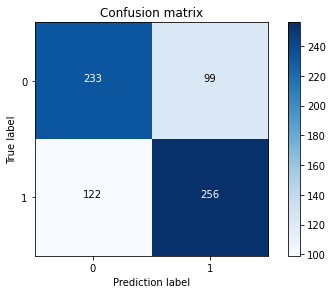

------6.Gaussian Naive Bayes------
accuracy on test set(Gaussian): 0.5464788732394367
recall(Gaussian): 0.09295774647887324
f1(Gaussian): 0.42904379445376806
AUC(Gaussian): 0.5464788732394367


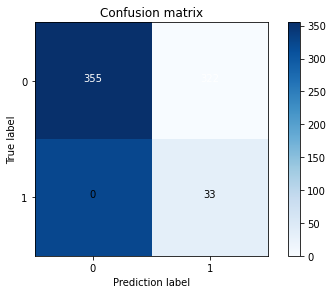

------7.Bernoulli Naive Bayes------
accuracy on test set(Bernoulli): 0.5788732394366197
recall(Bernoulli): 0.6422535211267606
f1(Bernoulli): 0.5771747248916994
AUC(Bernoulli): 0.5788732394366197


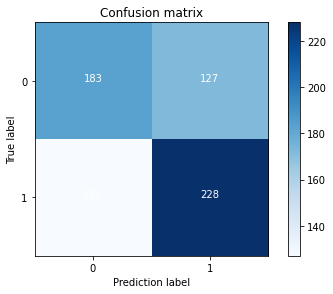

------8.SVM------
accuracy on test set(Bernoulli): 0.6450704225352113
recall(Bernoulli): 0.6
f1(Bernoulli): 0.6443479712806812
AUC(Bernoulli): 0.6450704225352113


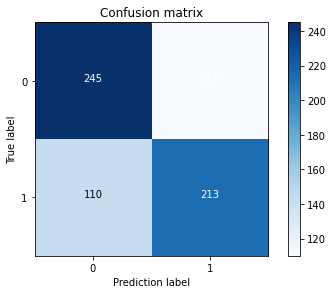

------9.MLP------
accuracy on test set(Bernoulli): 0.6281690140845071
recall(Bernoulli): 0.8535211267605634
f1(Bernoulli): 0.6082758620689654
AUC(Bernoulli): 0.6281690140845071


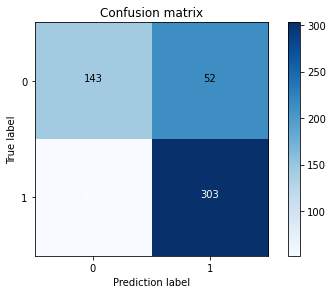

<Figure size 432x288 with 0 Axes>

In [18]:
print('------随机过采样------')
ros = RandomOverSampler(random_state=0)
X1 = np.array(df)
Y1 = y
X_resampled, y_resampled = ros.fit_resample(X1, Y1)
print(Counter(y_resampled))
x_train_1, x_test_1, y_train_1, y_test_1 = train_test_split(pd.DataFrame(X_resampled), y_resampled, test_size=0.2, random_state=1)
print('训练集类分布:')
print(Counter(y_train_1))
acc_test0, f10, recall0, auc0 = LR(x_train_1, x_test_1, y_train_1, y_test_1)
acc_test1, f11, recall1, auc1 = DT(x_train_1, x_test_1, y_train_1, y_test_1)
acc_test2, f12, recall2, auc2 = RF(x_train_1, x_test_1, y_train_1, y_test_1)
acc_test3, f13, recall3, auc3 = RFweight(x_train_1, x_test_1, y_train_1, y_test_1)
acc_test4, f14, recall4, auc4 = XGB(x_train_1, x_test_1, y_train_1, y_test_1)
acc_test5, f15, recall5, auc5 = NB_Gaussian(x_train_1, x_test_1, y_train_1, y_test_1)
acc_test6, f16, recall6, auc6 = NB_Bernoulli(x_train_1, x_test_1, y_train_1, y_test_1)
acc_test7, f17, recall7, auc7 = SVM(x_train_1, x_test_1, y_train_1, y_test_1)
acc_test8, f18, recall8, auc8 = MLP(x_train_1, x_test_1, y_train_1, y_test_1)
#loss3, acc_test9 = lstm(x_train_1, x_test_1, y_train_1, y_test_1)




------SMOTE过采样------
训练集类分布:
Counter({0: 1418, 1: 1418})
------1.LogisticRegression------
accuracy on test set: 0.6309859154929578
recall: 0.7577464788732394
f1: 0.6249596774193549
AUC: 0.6309859154929577


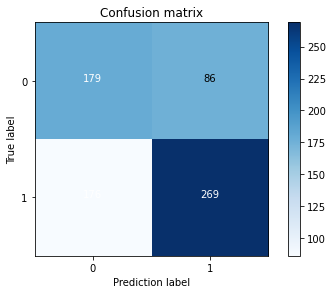

------2.DecisionTree------
accuracy on test set: 0.6661971830985915
recall: 0.647887323943662
f1: 0.6660852378599451
AUC: 0.6661971830985915


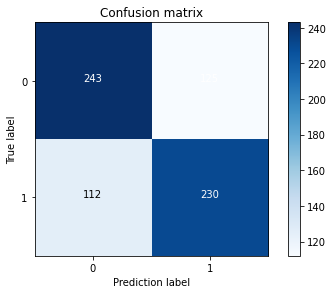

------3.RandomForest------
accuracy on test set: 0.676056338028169
recall: 0.7183098591549296
f1: 0.6754769475357711
AUC: 0.6760563380281691


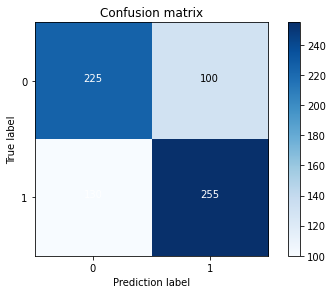

------4.RandomForest with weight------
accuracy on test set(balanced): 0.6788732394366197
recall(balanced): 0.7098591549295775
f1(balanced): 0.6785646206633626
AUC(balanced): 0.6788732394366197

accuracy on test set(weight): 0.5774647887323944
recall(weight): 0.9746478873239437
f1(weight): 0.498323032861019
AUC(weight): 0.5774647887323944


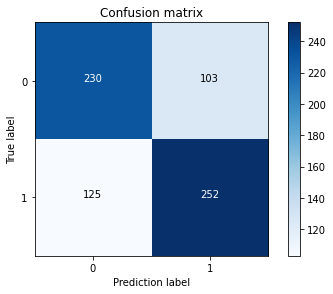

------5.XGBoost------
accuracy on test set: 0.6704225352112676
recall: 0.6985915492957746
f1: 0.670160810005956
AUC: 0.6704225352112676


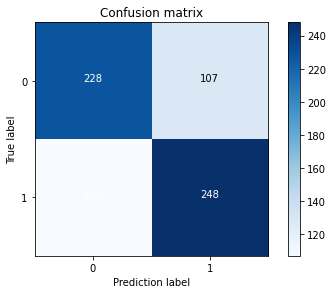

------6.Gaussian Naive Bayes------
accuracy on test set(Gaussian): 0.5267605633802817
recall(Gaussian): 0.05352112676056338
f1(Gaussian): 0.3901902843529207
AUC(Gaussian): 0.5267605633802817


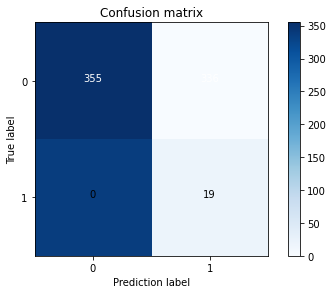

------7.Bernoulli Naive Bayes------
accuracy on test set(Bernoulli): 0.6014084507042253
recall(Bernoulli): 0.6816901408450704
f1(Bernoulli): 0.5988228035882928
AUC(Bernoulli): 0.6014084507042253


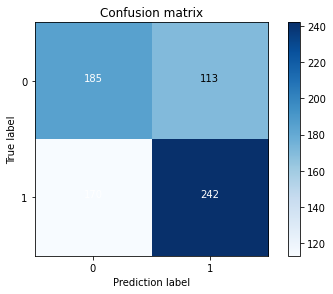

------8.SVM------
accuracy on test set(Bernoulli): 0.6591549295774648
recall(Bernoulli): 0.7577464788732394
f1(Bernoulli): 0.6558092948717948
AUC(Bernoulli): 0.6591549295774647


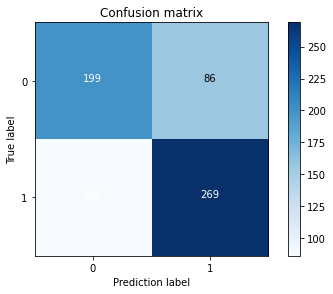

------9.MLP------
accuracy on test set(Bernoulli): 0.6676056338028169
recall(Bernoulli): 0.6845070422535211
f1(Bernoulli): 0.6675106556921636
AUC(Bernoulli): 0.6676056338028169


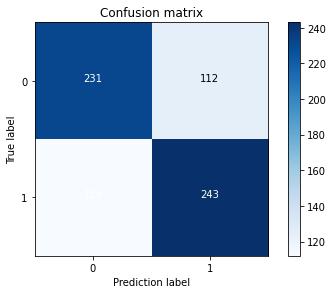

------10.LSTM------
Epoch 1/20
23/23 [==============================] - 1s 4ms/step - loss: 0.7503 - accuracy: 0.5194
Epoch 2/20
23/23 [==============================] - 0s 3ms/step - loss: 0.7033 - accuracy: 0.5487
Epoch 3/20
23/23 [==============================] - 0s 3ms/step - loss: 0.7004 - accuracy: 0.5557
Epoch 4/20
23/23 [==============================] - 0s 3ms/step - loss: 0.6918 - accuracy: 0.5515
Epoch 5/20
23/23 [==============================] - 0s 3ms/step - loss: 0.6885 - accuracy: 0.5716
Epoch 6/20
23/23 [==============================] - 0s 3ms/step - loss: 0.6799 - accuracy: 0.5776
Epoch 7/20
23/23 [==============================] - 0s 3ms/step - loss: 0.6788 - accuracy: 0.5670
Epoch 8/20
23/23 [==============================] - 0s 3ms/step - loss: 0.6741 - accuracy: 0.5885
Epoch 9/20
23/23 [==============================] - 0s 3ms/step - loss: 0.6660 - accuracy: 0.6012
Epoch 10/20
23/23 [==============================] - 0s 3ms/step - loss: 0.6666 - accuracy: 0.5917

<Figure size 432x288 with 0 Axes>

In [19]:
print('------SMOTE过采样------')
X3, Y3 = SMOTE().fit_resample(X1, Y1)
x_train_3, x_test_3, y_train_3, y_test_3 = train_test_split(pd.DataFrame(X3), Y3, test_size=0.2, random_state=1)
print('训练集类分布:')
print(Counter(y_train_3))

acc_test0, f10, recall0, auc0 = LR(x_train_3, x_test_3, y_train_3, y_test_3)
acc_test1, f11, recall1, auc1 = DT(x_train_3, x_test_3, y_train_3, y_test_3)
acc_test2, f12, recall2, auc2 = RF(x_train_3, x_test_3, y_train_3, y_test_3)
acc_test3, f13, recall3, auc3 = RFweight(x_train_3, x_test_3, y_train_3, y_test_3)
acc_test4, f14, recall4, auc4 = XGB(x_train_3, x_test_3, y_train_3, y_test_3)
acc_test5, f15, recall5, auc5 = NB_Gaussian(x_train_3, x_test_3, y_train_3, y_test_3)
acc_test6, f16, recall6, auc6 = NB_Bernoulli(x_train_3, x_test_3, y_train_3, y_test_3)
acc_test7, f17, recall7, auc7 = SVM(x_train_3, x_test_3, y_train_3, y_test_3)
acc_test8, f18, recall8, auc8 = MLP(x_train_3, x_test_3, y_train_3, y_test_3)
loss1, acc_test9 = lstm(x_train_3, x_test_3, y_train_3, y_test_3)

------分层采样------
0    0.805543
1    0.194457
Name: delay, dtype: float64
训练集类分布:
Counter({0: 1418, 1: 342})
0    0.805682
1    0.194318
Name: delay, dtype: float64
------1.LogisticRegression------
accuracy on test set: 0.8208616780045351
recall: 0.08139534883720931
f1: 0.5252054458481541
AUC: 0.5406976744186046


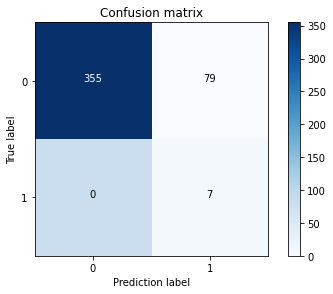

------2.DecisionTree------
accuracy on test set: 0.8117913832199547
recall: 0.09302325581395349
f1: 0.5278068036688727
AUC: 0.53946937438585


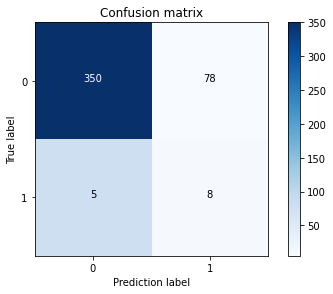

------3.RandomForest------
accuracy on test set: 0.8095238095238095
recall: 0.09302325581395349
f1: 0.5262915601023017
AUC: 0.5380609236816246


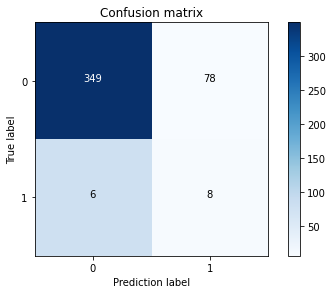

------4.RandomForest with weight------
accuracy on test set(balanced): 0.63718820861678
recall(balanced): 0.5116279069767442
f1(balanced): 0.5512363895390251
AUC(balanced): 0.5896167703897806

accuracy on test set(weight): 0.47619047619047616
recall(weight): 0.7674418604651163
f1(weight): 0.45927482921702567
AUC(weight): 0.5865378316410089


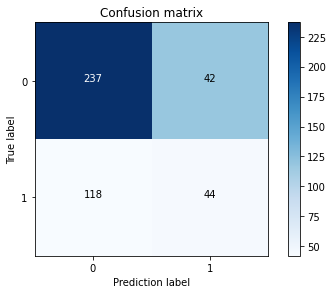

------5.XGBoost------
accuracy on test set: 0.8027210884353742
recall: 0.11627906976744186
f1: 0.5373289116671691
AUC: 0.5426465771372421


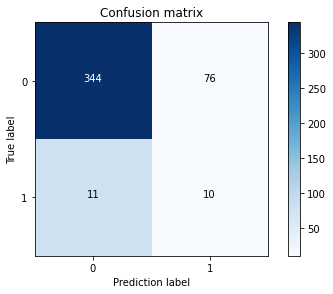

------6.Gaussian Naive Bayes------
accuracy on test set(Gaussian): 0.8208616780045351
recall(Gaussian): 0.08139534883720931
f1(Gaussian): 0.5252054458481541
AUC(Gaussian): 0.5406976744186046


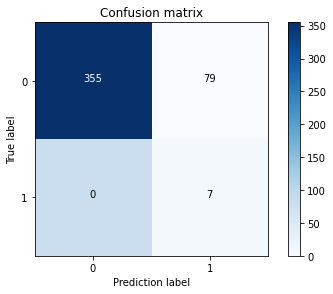

------7.Bernoulli Naive Bayes------
accuracy on test set(Bernoulli): 0.7891156462585034
recall(Bernoulli): 0.12790697674418605
f1(Bernoulli): 0.5350263590499404
AUC(Bernoulli): 0.5386013756960366


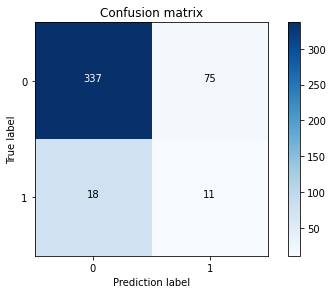

------8.SVM------
accuracy on test set(Bernoulli): 0.81859410430839
recall(Bernoulli): 0.06976744186046512
f1(Bernoulli): 0.5145844799119428
AUC(Bernoulli): 0.5348837209302325


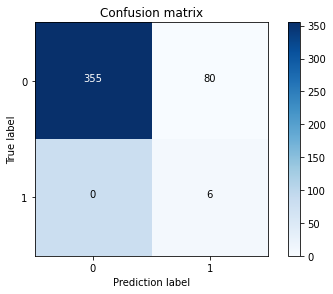

------9.MLP------
accuracy on test set(Bernoulli): 0.8117913832199547
recall(Bernoulli): 0.10465116279069768
f1(Bernoulli): 0.5359719070498599
AUC(Bernoulli): 0.5438748771699967


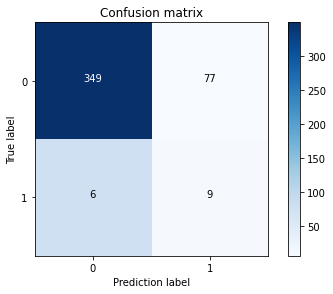

<Figure size 432x288 with 0 Axes>

In [20]:
print('------分层采样------')
X2 = np.array(df)
Y2 = y
print(y.value_counts() / len(Y2))
split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train_index, test_index in split.split(X2, Y2):
    x_train_2, x_test_2 = X2[train_index], X2[test_index]  # 训练集对应的值
    y_train_2, y_test_2 = Y2[train_index], Y2[test_index]  # 类别集对应的值
print('训练集类分布:')
print(Counter(y_train_2))
print(y_train_2.value_counts() / len(y_train_2))
x_train_2 = pd.DataFrame(x_train_2)
x_test_2 = pd.DataFrame(x_test_2)

acc_test0, f10, recall0, auc0 = LR(x_train_2, x_test_2, y_train_2, y_test_2)
acc_test1, f11, recall1, auc1 = DT(x_train_2, x_test_2, y_train_2, y_test_2)
acc_test2, f12, recall2, auc2 = RF(x_train_2, x_test_2, y_train_2, y_test_2)
acc_test3, f13, recall3, auc3 = RFweight(x_train_2, x_test_2, y_train_2, y_test_2)
acc_test4, f14, recall4, auc4 = XGB(x_train_2, x_test_2, y_train_2, y_test_2)
acc_test5, f15, recall5, auc5 = NB_Gaussian(x_train_2, x_test_2, y_train_2, y_test_2)
acc_test6, f16, recall6, auc6 = NB_Bernoulli(x_train_2, x_test_2, y_train_2, y_test_2)
acc_test7, f17, recall7, auc7 = SVM(x_train_2, x_test_2, y_train_2, y_test_2)
acc_test8, f18, recall8, auc8 = MLP(x_train_2, x_test_2, y_train_2, y_test_2)
#loss2, acc_test9 = lstm(x_train_2, x_test_2, y_train_2, y_test_2)